In [179]:
import pandas as pd                                                             
import matplotlib.pyplot as plt                                                 
import seaborn as sns 
import numpy as np
from sklearn.preprocessing import RobustScaler                                 
from imblearn.over_sampling import SMOTE                                        # for balancing imbalanced classes
from sklearn.model_selection import train_test_split, GridSearchCV              # for splitting the data and hyperparameter tuning
from sklearn.linear_model import LogisticRegression                             # for logistic regression model
from sklearn.metrics import accuracy_score                                      # for model evaluation                            
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay            # for showing confusion matrix
from sklearn.metrics import classification_report                               # for showing precision, recall, f1-score
from sklearn.metrics import roc_curve, roc_auc_score                            # for roc curve and auc score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier                                               # for XGBoost model           
from sklearn.model_selection import KFold, cross_val_score                      # for cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # Import the Support Vector Classifier

In [110]:
# Load the dataset
df = pd.read_csv('bank_cleaned.csv')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,outcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0


Data Preprocessing 

In [112]:
# check for missing values
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
outcome      0
y            0
dtype: int64

In [114]:
# info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  outcome    45211 non-null  object
 16  y          45211 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 5.9+ MB


In [116]:
# names of columns
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'outcome', 'y'],
      dtype='object')

In [118]:
# check for duplicate rows
print("Number of duplicate rows: ", df.duplicated().sum())

Number of duplicate rows:  0


In [120]:
df['default'] = df['default'].map({'yes': 1, 'no': 0})
df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
df['outcome'] = df['outcome'].map({'success': 1, 'failure': 0, 'other': 2, 'unknown': 3})

# Verify the transformation
print(df[['default', 'housing', 'loan', 'outcome']].head())


   default  housing  loan  outcome
0        0        1     0        3
1        0        1     0        3
2        0        1     1        3
3        0        1     0        3
4        0        0     0        3


In [122]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,outcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,3,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,3,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,3,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,3,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,3,0


Exploratory Data Analysis 

In [124]:
# summary of the dataset
df.describe()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,outcome,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,0.018027,1362.272058,0.555838,0.160226,15.806419,258.163080,2.763841,40.197828,0.580323,2.567251,0.116985
std,10.618762,0.133049,3044.765829,0.496878,0.366820,8.322476,257.527812,3.098021,100.128746,2.303441,0.981202,0.321406
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000
25%,33.000000,0.000000,72.000000,0.000000,0.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,3.000000,0.000000
50%,39.000000,0.000000,448.000000,1.000000,0.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,3.000000,0.000000
75%,48.000000,0.000000,1428.000000,1.000000,0.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,3.000000,0.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,3.000000,1.000000


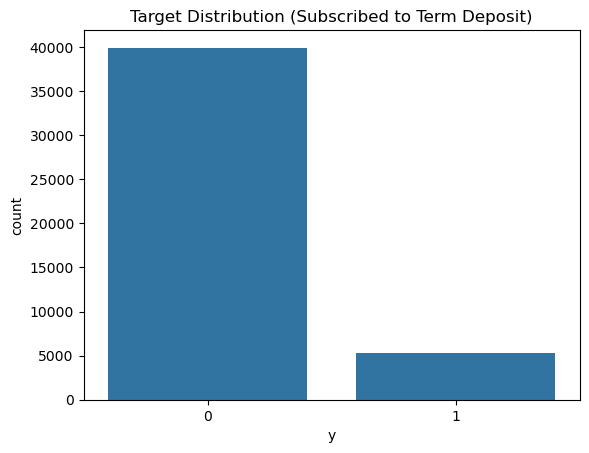

In [126]:
# Distribution of target variable 'y' (whether the customer subscribed to the term deposit)
sns.countplot(x='y', data=df)
plt.title('Target Distribution (Subscribed to Term Deposit)')
plt.show()


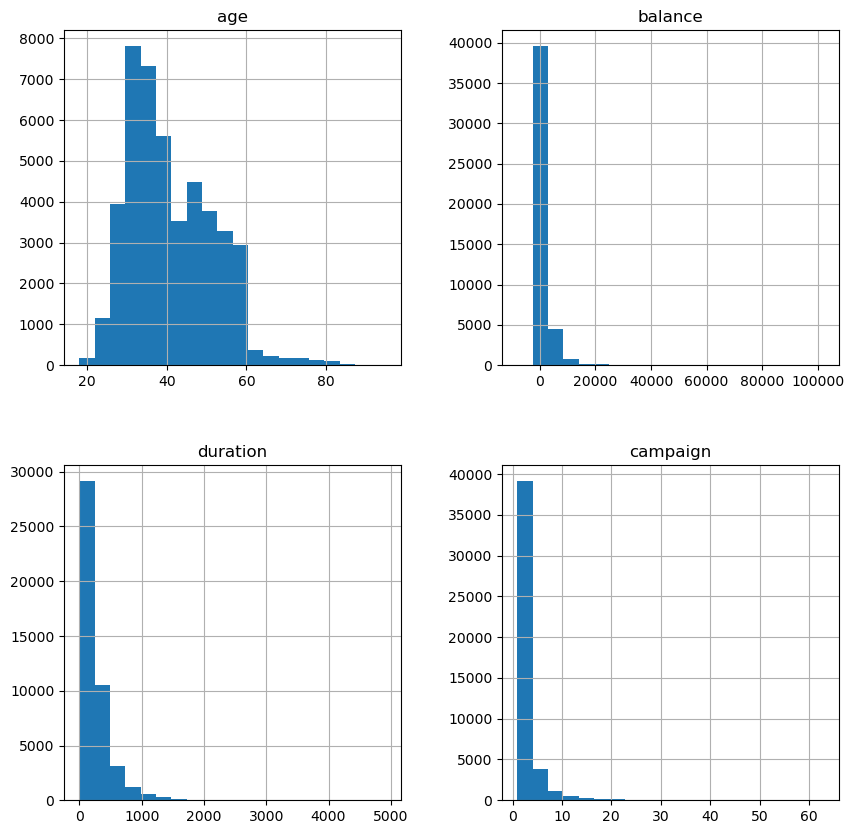

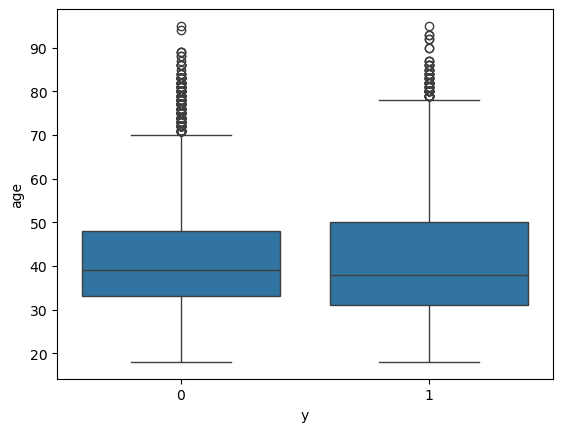

In [128]:
# Visualize distribution of numerical features
df[['age', 'balance', 'duration', 'campaign']].hist(bins=20, figsize=(10, 10))
plt.show()

# Boxplot for age vs target variable
sns.boxplot(x='y', y='age', data=df)
plt.show()


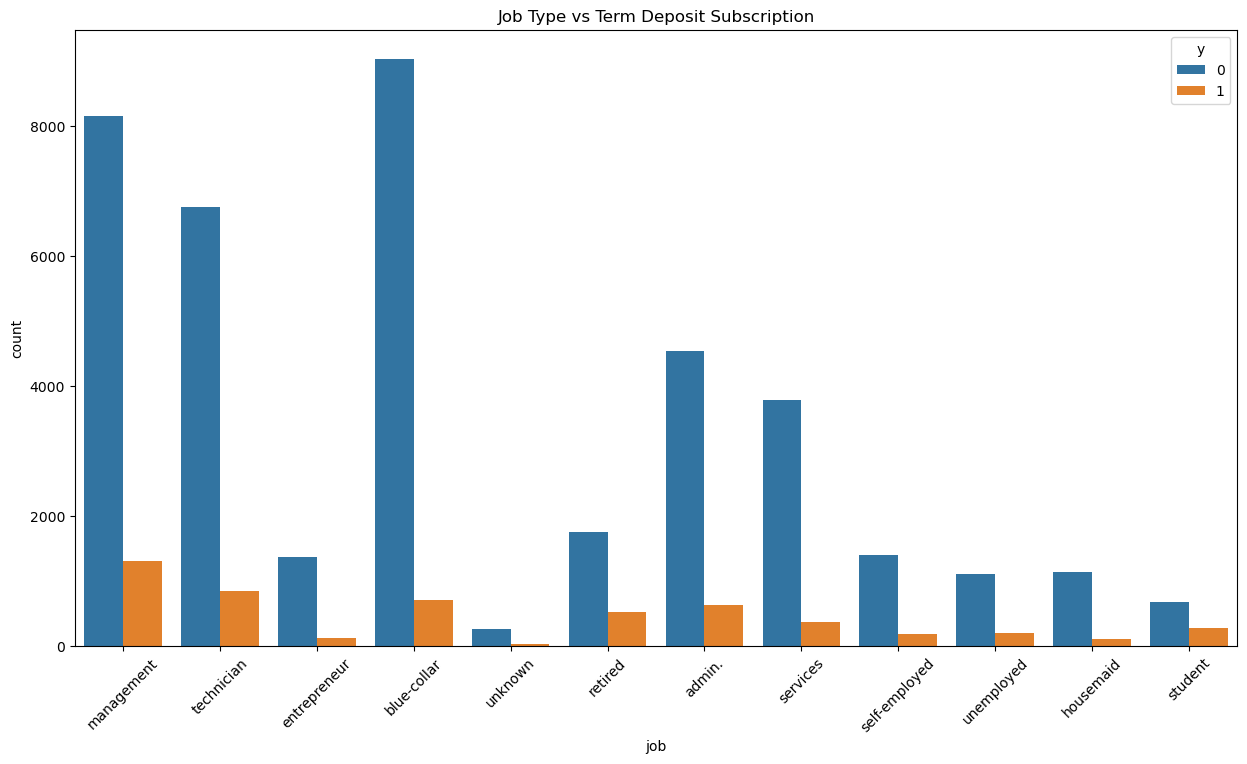

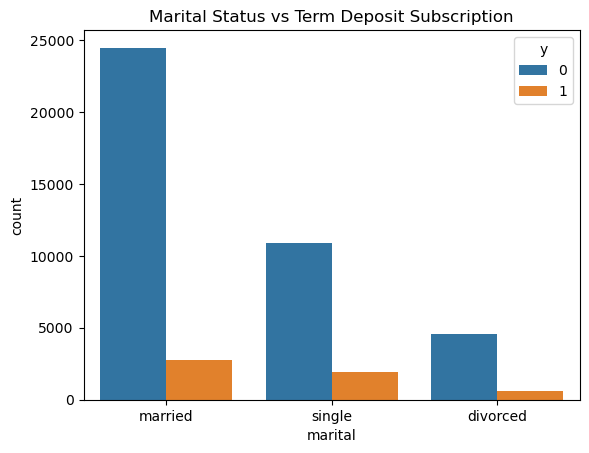

In [87]:
plt.figure(figsize=(15, 8))  # Adjust width and height as needed
sns.countplot(x='job', hue='y', data=df)
plt.title('Job Type vs Term Deposit Subscription')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

sns.countplot(x='marital', hue='y', data=df)
plt.title('Marital Status vs Term Deposit Subscription')
plt.show()


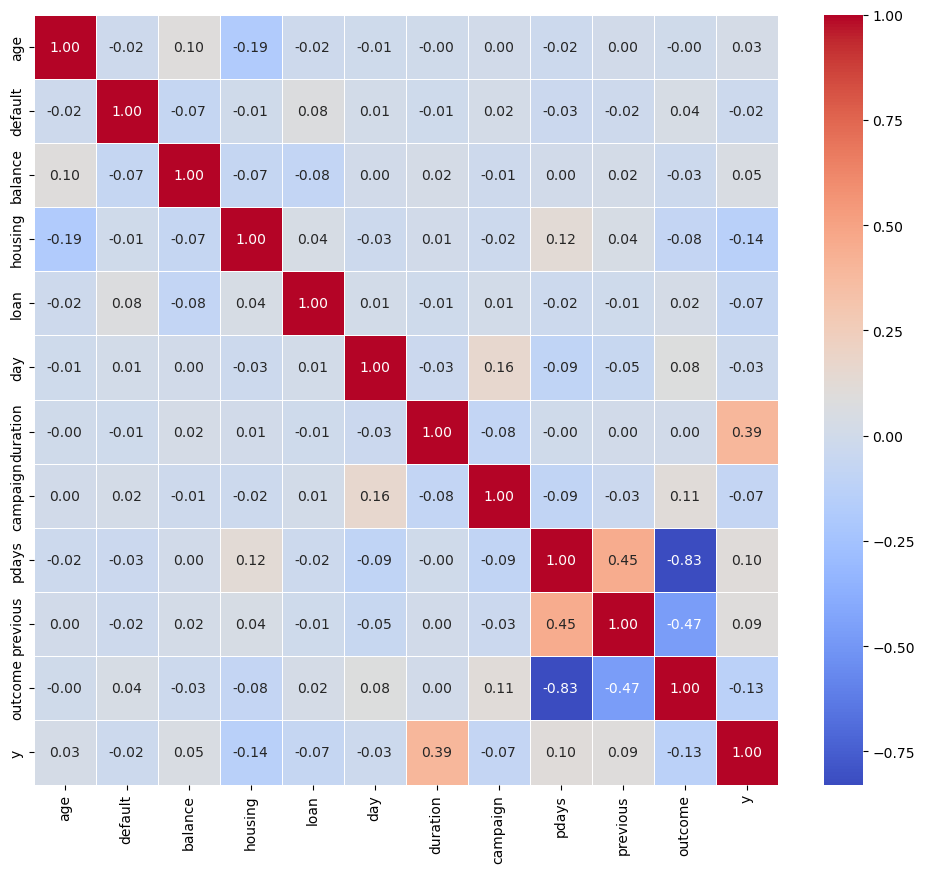

In [88]:
# Select only numerical columns for correlation matrix
numerical_cols = df.select_dtypes(include=['number']).columns

# Calculate the correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()


In [89]:
# One-Hot Encoding for categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Check the transformed dataset
print(df_encoded.head())


   age  default  balance  housing  loan  day  duration  campaign  pdays  \
0   58        0     2143        1     0    5       261         1     -1   
1   44        0       29        1     0    5       151         1     -1   
2   33        0        2        1     1    5        76         1     -1   
3   47        0     1506        1     0    5        92         1     -1   
4   33        0        1        0     0    5       198         1     -1   

   previous  ...  month_dec  month_feb  month_jan  month_jul  month_jun  \
0         0  ...      False      False      False      False      False   
1         0  ...      False      False      False      False      False   
2         0  ...      False      False      False      False      False   
3         0  ...      False      False      False      False      False   
4         0  ...      False      False      False      False      False   

   month_mar  month_may  month_nov  month_oct  month_sep  
0      False       True      False     

In [ ]:
Model Tuning

In [151]:
# Step 1: Split the data into features (X) and target (y)
X = df_encoded.drop(columns='y')  # Features
y = df_encoded['y']  # Target variable

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

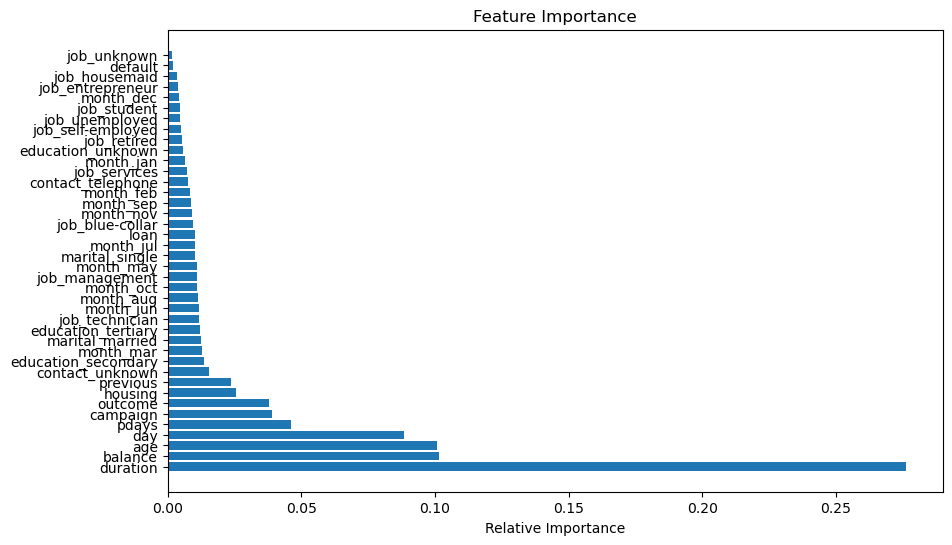

In [155]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Plot feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Now np is defined

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlabel("Relative Importance")
plt.show()

In [161]:
# Initialize and train the Logistic Regression model
logreg_model = LogisticRegression(random_state=42, solver='liblinear', max_iter=500)
logreg_model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_logreg = logreg_model.predict(X_test)


In [163]:
# Evaluate Logistic Regression model's performance
mse_logreg = mean_squared_error(y_test, y_pred_logreg)
r2_logreg = r2_score(y_test, y_pred_logreg)
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)

# Print the results for Logistic Regression
print("Logistic Regression Results:")
print(f"MSE: {mse_logreg:.4f}")
print(f"R²: {r2_logreg:.4f}")
print(f"Accuracy: {accuracy_logreg:.4f}")
print(f"Precision: {precision_logreg:.4f}")
print(f"Recall: {recall_logreg:.4f}")
print(f"F1-Score: {f1_logreg:.4f}")

Logistic Regression Results:
MSE: 0.1077
R²: -0.0152
Accuracy: 0.8923
Precision: 0.6163
Recall: 0.2841
F1-Score: 0.3890


In [177]:
# Assuming df_encoded is your dataframe
# Split the data into features (X) and target (y)
X = df_encoded.drop(columns='y')  # Features
y = df_encoded['y']  # Target variable

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize and train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)  # Train on the balanced dataset

# Make predictions with Random Forest
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest model's performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Print the results for Random Forest
print("Random Forest Results:")
print(f"MSE: {mse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-Score: {f1_rf:.4f}")


Random Forest Results:
MSE: 0.1022
R²: 0.0369
Accuracy: 0.8978
Precision: 0.5865
Recall: 0.5188
F1-Score: 0.5506


In [169]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

# Evaluate XGBoost model's performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

# Print the results for XGBoost
print(f"XGBoost - MSE: {mse_xgb:.4f}")
print(f"XGBoost - R²: {r2_xgb:.4f}")
print(f"XGBoost - Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost - Precision: {precision_xgb:.4f}")
print(f"XGBoost - Recall: {recall_xgb:.4f}")
print(f"XGBoost - F1-Score: {f1_xgb:.4f}")


XGBoost - MSE: 0.0947
XGBoost - R²: 0.1078
XGBoost - Accuracy: 0.9053
XGBoost - Precision: 0.6485
XGBoost - Recall: 0.4702
XGBoost - F1-Score: 0.5452


In [181]:
# Initialize and train the SVM model
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions with SVM
y_pred_svm = svm_model.predict(X_test)

# Evaluate SVM model's performance
mse_svm = mean_squared_error(y_test, y_pred_svm)
r2_svm = r2_score(y_test, y_pred_svm)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

# Print the results for Support Vector Machine
print("\nSupport Vector Machine Results:")
print(f"MSE: {mse_svm:.4f}")
print(f"R²: {r2_svm:.4f}")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")
print(f"F1-Score: {f1_svm:.4f}")



Support Vector Machine Results:
MSE: 0.1205
R²: -0.1362
Accuracy: 0.8795
Precision: 0.5385
Recall: 0.0064
F1-Score: 0.0127
